<a href="https://colab.research.google.com/github/hayunjong83/computer_vision_implement_research/blob/master/keras_official_examples/image_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image classification from scratch**
===
케라스 공식 코드 예제 中 **Computer Vision (1)**

원본 글 : [Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)



---


캐글 **Cats vs Dogs 데이터셋**을 분류하는 이미지 분류 모델을 사전학습된 모델을 사용(**전이학습)하지 않고**, 처음부터 학습시킨다.

---

Tensorflow nightly버전 설치
---
예제에서 사용하는 tensorflow.keras.preprocessing.image_dataset_from_directory()같은 함수는 tensorflow 2.2버전까지는 포함되어 있지 않다.

tensorflow 2.3 버전 이후에는 포함될 것으로 보이지만, 200616 현재 colab에서는 tensorflow 2.2.x 버전이 사용되고 있다.

공식예제를 따라 실행하고 이해하는 것을 목표로 하고 있다. 따라서  여기에서는 [참고](https://github.com/keras-team/keras-io/issues/12)의 내용처럼 tf-nightly 빌드를 설치하여 예제를 실행하려고 한다.
>```python
pip install --upgrade tf-nightly
pip install --upgrade tf-nighptly-gpu
```

tf-nightly는 tensorflow의 일일 빌드 버전이다. 빌드의 성격상 불안정할 수 있다. 

In [ ]:
!pip install --upgrade tf-nightly-gpu

     |████████████████████████████████| 350.3MB 50kB/s 
     |████████████████████████████████| 460kB 55.3MB/s 
     |████████████████████████████████| 3.0MB 51.4MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
print(tf.__version__)
print(tf.keras.__version__)
print(tf.test.is_gpu_available())

2.3.0-dev20200616
2.4.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


데이터 로드
---
이미지 [데이터](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip)를 불러온다. curl 명령어를 이용해서 직접 다운로드한다.
> ! 를 사용하면 터미널에서 입력할 명령어를 노트북에서 바로 실행시킬 수 있다.

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  15.1M      0  0:00:51  0:00:51 --:--:-- 15.0M


In [ ]:
!unzip -q kagglecatsanddogs_3367a.zip

공식예제에 나와 있는 것처럼 **unzip** 명령어를 이용해서 이미지 데이터를 압축해제한다.
> Windows 10 환경에서는 직접 탐색기에서 압축해제하면 된다. 하지만 **cmd**에서 압축해제하려면 [zip and unzip for windows10](http://stahlworks.com/dev/index.php?tool=zipunzip)에서 **unzip.exe**를 받아서 **C:\Windows\System32**에 복사해주면 된다.
마찬가지로 **zip.exe**를 받아서 저장해주면 cmd 상에서 압축할 수 있다.

In [ ]:
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [ ]:
!ls PetImages

Cat  Dog


**tf.compat**은 호환성 함수(Compatibility function)을 위한 모듈이다. 텐서플로 1.x 코드를 사용하기 위한 **tf.compat.v1** 모듈 등이 있다. [tf.compat.as_bytes](https://www.tensorflow.org/api_docs/python/tf/compat/as_bytes)는 입력을 bytes로 변환해준다.


---
여기에서는 디코딩하여 **이진 바이트배열**로 읽은 이미지 파일의 **헤더**를 확인한다. 잘못 인코딩된(badly-encoded)이미지를 걸러내기 위해서다.
> 손실압축기법인 **JPEG(Joint Photographic Experts Group)**으로 압축된 파일은 *JPG* 또는 *JPEG* 확장자를 가지고, **JFIF(JPEG File Interchange Format)**으로 저장된다.
```
바르게  인코딩된 파일은 JPEG 표준포맷정의에 따라 
6 번째 바이트부터 4 바이트가 
JFIF의 바이트 표현인 4a 46 49 46 이 된다.
```


In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
  folder_path = os.path.join("PetImages", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1
      # Delete corrupted image
      os.remove(fpath)

  print("Delete %d images" % num_skipped) 

Delete 759 images
Delete 1590 images


데이터셋 생성
---
[image_dataset_from_directory](https://keras.io/api/preprocessing/image/)유틸리티를 이용해서 데이터셋을 생성한다.
여기서 ImageDataGenerator 등을 사용해서 데이터를 먼저 확장하지 않고, 뒤에서 preprocessing 함수를 이용한다.(*image augmentation*)

- 이미지의 크기는 (180, 180)으로 설정하고, 배치 크기는 32개로 한다.
- 20%의 데이터를 검증 데이터(validation data)로 사용한다.
- 공식 예제의 결과와 비교해보기 위해, 동일한 시드값을 사용했다.

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset="training",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset="validation",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


데이터 시각화
---
데이터가 제대로 준비되었는지 확인하기 위해, 몇 개의 이미지를 시각화한다. 

image_dataset_from_directory 함수는 서브디렉토리를 순서대로 레이블링하므로 **고양이**는 **0**으로, **개**는 **1**로 표현된다.

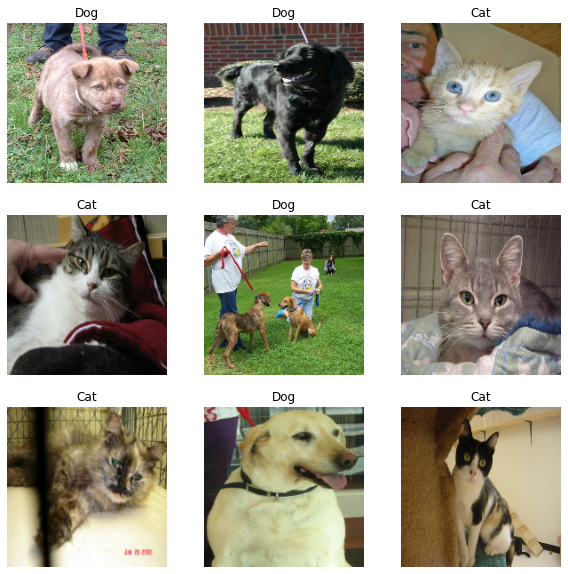

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    if (int(labels[i])==0):
      plt.title("Cat")
    else:
      plt.title("Dog")
    plt.axis("off")

데이터 확장
---
data augmentation은 데이터 수가 충분하지 않을 때, 훈련 데이터에 반전, 회전, 변형 등의 조작을 가하여 훈련 데이터를 확장하는 것을 의미한다. overfitting을 방지하는 방법 중의 하나로 생각할 수 있다.

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

> **tf.keras.layers.experimental.preprocessing.RandomFlip()**는 플래그(**"horizontal", "vertical", "horizontal_and_vertical"**)에 따라 이미지를 **반전**시킨다.

> **tf.keras.layers.experimental.preprocessing.RandomRotation()**는 이미지를 무작위로 회전한다. **factor** : 0부터 1 사이의 단일 실수 값은 회전할 비율을 의미하고, 튜플은 반시계방향(음수), 시계방향(양수)의 상한,하한 비율을 
뜻한다. **interpolation** : 회전시 보간(interpolation)방식은 최근접보간법("nearest")과 양-선형보간법("bilinear")을 사용할 수 있다.

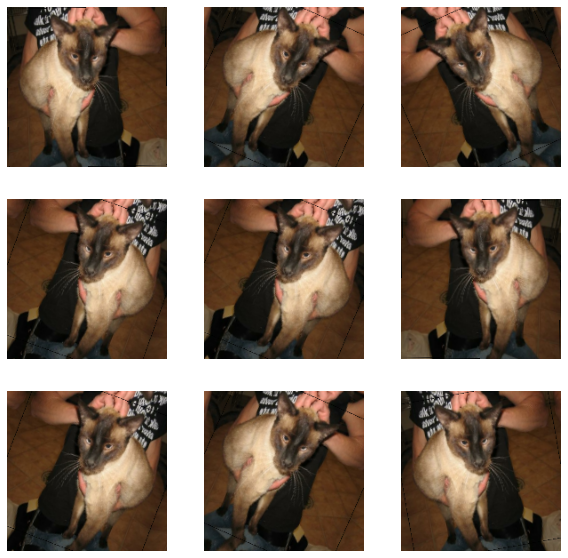

In [ ]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

데이터 표준화
---
기본적인 RGB 이미지의 픽셀값은 0 부터 255 사이의 값이다. 신경망에서 입력값은 성능을 위하여 표준화하는 것이 좋다. 각 특성값의 범위가 다르면, 때때로 큰 범위의 값이 신경망에 더 큰 영향을 미칠 가능성이 있기 때문이다.

여기서는 Rescaling 레이어를 이용해서 0 부터 1 사이의 값으로 픽셀값을 **표준화(standardize)**한다.


**데이터 전처리(data preprocessing)**의 두 가지 적용방식
---

**방법 1.** 모델의 일부분으로 표준화를 실시한다.
> ```
inputs = keras.Input(shape = input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
... # Rest of the model
```
이 방법을 이용하면, 데이터 확장이 모델의 나머지 부분이 실행될 때 동시에 GPU에서 이뤄질 수 있다. 따라서 GPU 가속의 장점을 활용할 수 있다. **공식 예제는 방법 1을 사용한다.**

**방법 2.** 데이터셋에 먼저 전처리를 적용하여 확장된 데이터 배치를 획득한 후에 모델을 실행한다.
> ```
augmented_train_ds = train_ds.map(
  lambda x, y : (data_augmentation(x, training=True), y))
  ```
이 방법은 CPU에서 데이터를 확장하므로, 데이터를 신경망 모델에 입력하기 전에 미리 확장된 데이터를 버퍼해 놓는다. CPU 버전의 tf-nightly를 사용한다면, **방법 2**가 더 좋을 수 있다. 데이터 확장이 CPU에서 비동기적이며 non-blocking으로 동작하여서, 모델 실행을 방해하지 않게 된다.



성능을 위한 데이터셋 설정
---
**프리페치(prefetch)**를 사용한다. 이렇게 되면 I/O가 실행을 blocking 하는 일 없이 데이터셋을 얻을 수 있으므로 성능이 크게 향상된다.

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size = 32)

모델 생성
---
축소된 버전의 Xception network를 만든다. 여기서는 모델의 최적화를 중점에 두지 않고, 최적의 모델 설정을 위해 [Keras Tuner](https://github.com/keras-team/keras-tuner)를 소개하고 있다.

**Xception network**

케라스의 창시자이며, 이 공식 예제를 기술한 프랑수와 숄레가 2016년 제안한 모델이다. extreme inception의 의미에서 Xception으로 명명되었다.

ResNet처럼 잔차학습(residual learning)을 하는 스킵 연결(skip connection)을 가지고 있고, **depthwise separable convolution layer(깊이별 분리 합성곱)**를 이용해서 공간 패턴과 채널 패턴을 분리하여 모델링한다. 

Keras에서는 **[keras.layers.SeparableConv2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2D?version=nightly)**를 사용해 깊이별 분리 합성곱 연산을 한다. 각 입력 채널 혹은 입력 특성맵 별로 spatial convolution을 수행하고, 이어서 1x1 필터를 통한 pointwise convolution을 수행해준다.

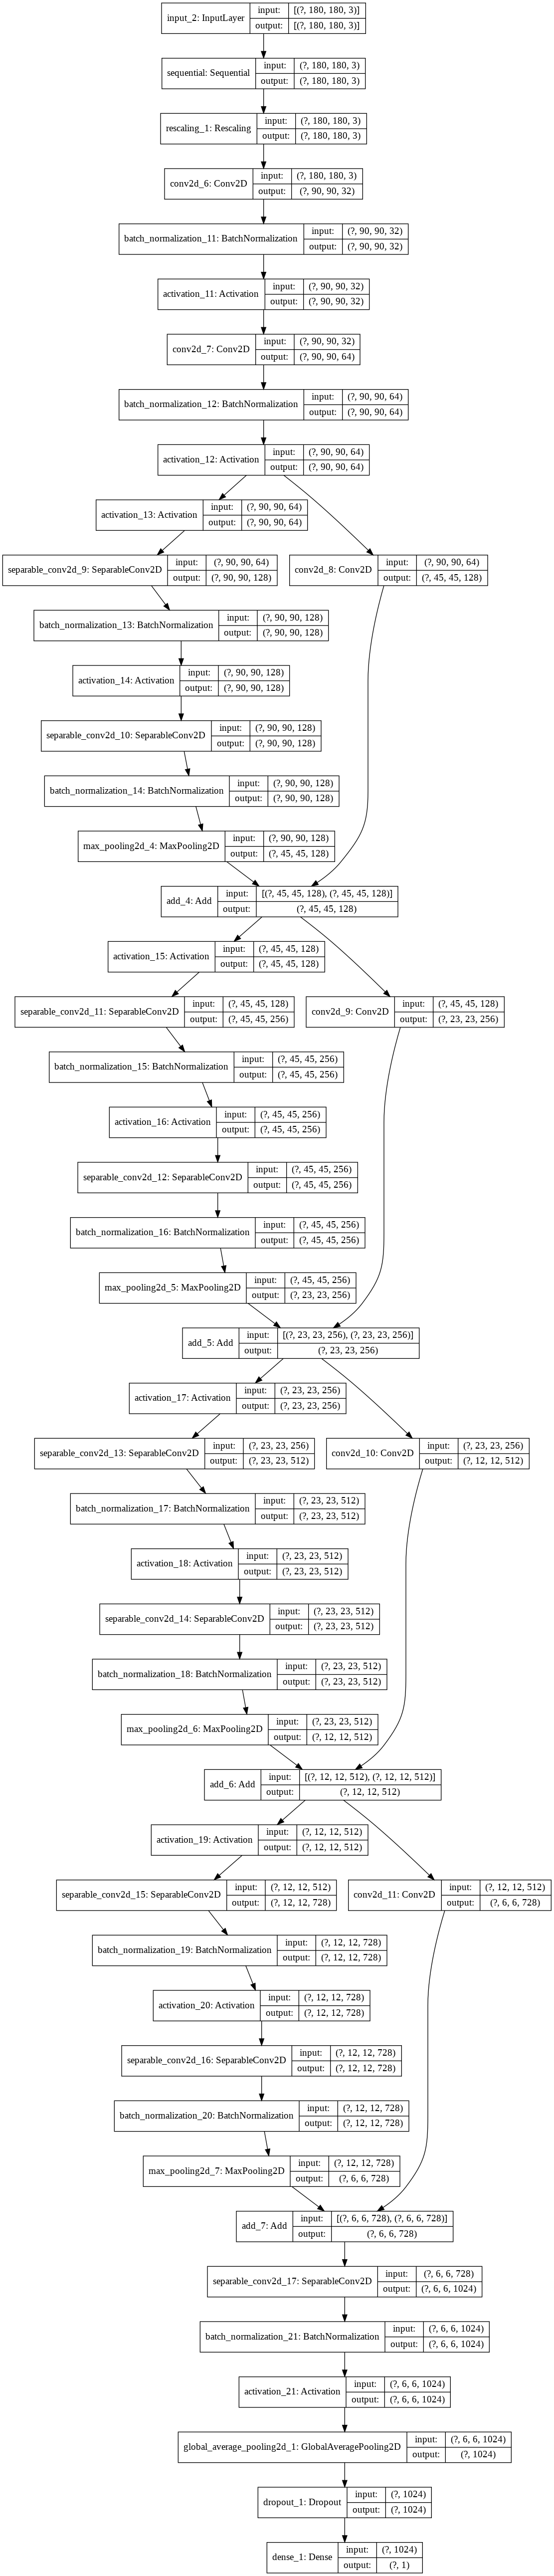

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    
    # Entry block
    x = keras.layers.experimental.preprocessing.Rescaling(1.0/255)(x)
    x = keras.layers.Conv2D(32, 3, strides = 2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    
    x = keras.layers.Conv2D(64, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    
    previous_block_activation = x  # Set aside residual
    
    for size in [128, 256, 512, 728]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)
        
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)
        
        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        # Project residual
        residual = keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation        
        )
        x = keras.layers.add([x, residual])   # Acc back residual
        previous_block_activation = x         # Set aside next residual
        
    x = keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, to_file = 'model.png', show_shapes=True)

참고로 [keras.utils.plot_model()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model?version=nightly)은 구성한 신경망 모델을 dot 포맷으로 바꿔주고, 간단하게 시각적으로 확인할 수 있게 해준다. to_file 값을 설정해주면 GraphViz로 생성된 그래프를 저장할 수 있다. 참고를 위해 model.png로 저장해보았다.
> colab에서는 이미 설치되어 있지만 만약 실행되지 않는 경우, pydot과 graphviz를 설치해준다.
```
pip install pydot graphviz
```

모델 훈련
---

In [ ]:
epochs = 50

callbacks = [
             keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")
]
model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)
model.fit(
    train_ds, epochs= epochs, callbacks=callbacks, validation_data = val_ds,
)

Epoch 1/50
586/586 [==============================] - 208s 354ms/step - loss: 0.5974 - accuracy: 0.6875 - val_loss: 0.5996 - val_accuracy: 0.6820
Epoch 2/50
586/586 [==============================] - 208s 355ms/step - loss: 0.4347 - accuracy: 0.7976 - val_loss: 0.5296 - val_accuracy: 0.7757
Epoch 3/50
586/586 [==============================] - 208s 356ms/step - loss: 0.3508 - accuracy: 0.8449 - val_loss: 0.3546 - val_accuracy: 0.8385
Epoch 4/50
586/586 [==============================] - 209s 356ms/step - loss: 0.2869 - accuracy: 0.8798 - val_loss: 0.2432 - val_accuracy: 0.8968
Epoch 5/50
586/586 [==============================] - 208s 354ms/step - loss: 0.2397 - accuracy: 0.9011 - val_loss: 0.3403 - val_accuracy: 0.8607
Epoch 6/50
586/586 [==============================] - 208s 354ms/step - loss: 0.2096 - accuracy: 0.9146 - val_loss: 0.7404 - val_accuracy: 0.7179
Epoch 7/50
586/586 [==============================] - 208s 354ms/step - loss: 0.1918 - accuracy: 0.9238 - val_loss: 0.2044 -

새로운 데이터에 대한 예측
---
모델에 사용되었던 data augmentation과 dropout은 inference 때, 자동으로 비활성화 된다.

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)


This image is 95.39 percent cat and 4.61 percent dog.
